In [227]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn import preprocessing
from sklearn.model_selection import *
from models import *
from scipy.signal import lfilter


## **Exploratory Data Analysis**

In [2]:
data = pickle.load(open(r'../Data/deltaQ_cycles_v3.pkl', 'rb'))
#data2 = pickle.load(open(r'../Data/temp_features.pkl', 'rb'))

print(data['b1c1'].keys())

dict_keys(['cycle_life', 'DeltaQ_logVars', 'DeltaQ_mins', 'DeltaQ_means', 'DeltaT_max', 'DeltaT_logVars', 'DeltaIR'])


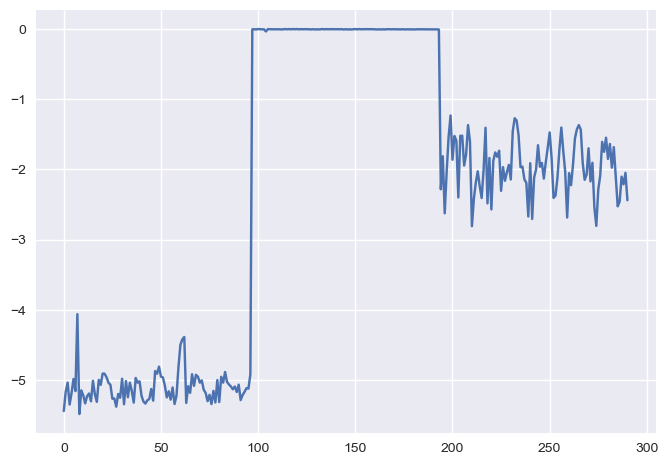

In [412]:
n_cycles = 98
cut_start = 1

features = [
    "DeltaQ_logVars",
    "DeltaQ_mins",
    #"DeltaQ_means",
    # "DeltaT_max",
    "DeltaT_logVars",
]

n_cycles = n_cycles - cut_start
y = np.zeros(124)
x = np.zeros((124, n_cycles*len(features)))

for i, cell in enumerate(data.keys()):
    for j, feature in enumerate(features):
        x[i, j*n_cycles:(j+1)*n_cycles] = data[cell][feature][cut_start:]
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)


plt.plot(x[1])

## **AutoEncoder: Dimensionality Reduction**

### **Train Test Split**

In [413]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])



Stage 1:

Epoch 40/400, loss: 50751.84
Epoch 80/400, loss: 26478.77
Epoch 120/400, loss: 19891.84
Epoch 160/400, loss: 14867.16
Epoch 200/400, loss: 11732.85
Epoch 240/400, loss: 10302.17
Epoch 280/400, loss: 9349.48
Epoch 320/400, loss: 8594.61
Epoch 360/400, loss: 7951.66
Epoch 400/400, loss: 7379.41
train 	 85.35426
test 	 96.553
sec 	 275.01154


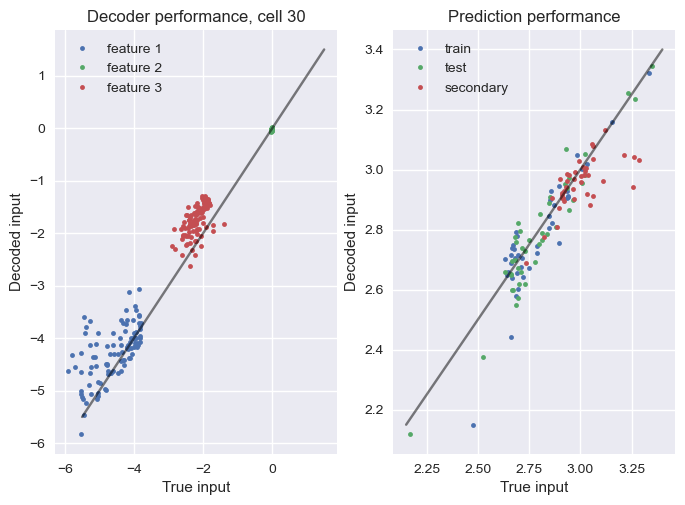


Stage 2:

Epoch 20/200, loss: 2.22
Epoch 40/200, loss: 2.15
Epoch 60/200, loss: 2.08
Epoch 80/200, loss: 2.03
Epoch 100/200, loss: 1.97
Epoch 120/200, loss: 1.92
Epoch 140/200, loss: 1.86
Epoch 160/200, loss: 1.81
Epoch 180/200, loss: 1.76
Epoch 200/200, loss: 1.70
train 	 64.360504
test 	 87.58894
sec 	 273.86496


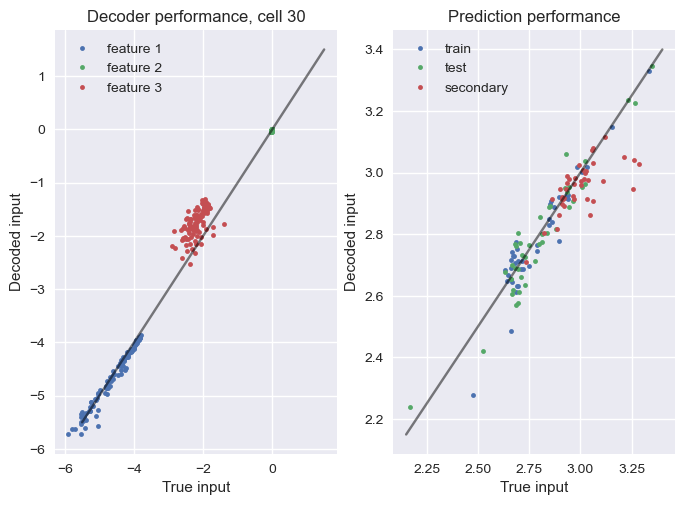

In [442]:
train_policy = {
    "num_stages": 2,
    "epochs": [400, 200],
    "learning_rates": [1e-4, 1e-4],
    "batch_sizes": [64, 64],
    "prediction_weights": [1, 0.0001],
    "decoding_weights": [50, 1],
    "en_weights": [1, 1]
}


model = AutoEncoder_ElasticNet(n_features=len(features), n_cycles=n_cycles)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(x,y, train_policy)

In [443]:
model.encoder(x[5])

tensor([0.0000, 3.2984, 0.5038, 0.0000, 2.0774, 0.0000, 2.2360, 3.3761, 0.6435,
        0.0000, 0.0000, 0.0000, 0.0000, 3.5184, 0.3699, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4096, 0.0000, 0.0000, 0.9752, 0.2970, 0.0000, 2.8831, 1.0942,
        0.0000, 0.0000, 0.0000, 0.4667, 3.4531, 0.0000, 1.7866, 2.9467, 0.0000,
        0.4711, 1.2099, 0.0000, 0.5985, 3.4344, 0.6905, 0.0000, 4.3251, 1.9399,
        0.0000, 0.0000, 0.0000], grad_fn=<ReluBackward0>)

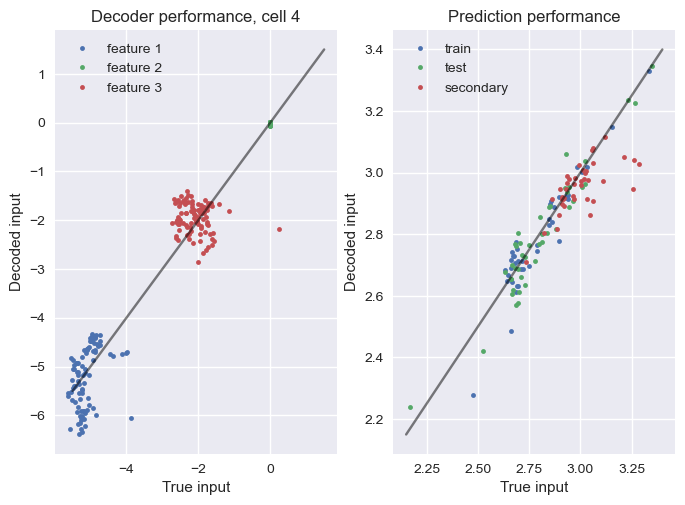

In [444]:
model.plotter(x, y, 4)

In [445]:
print(y[1], model.elastic_net_predict(x[1]))

tensor(3.3345) tensor([3.3313], grad_fn=<AddBackward0>)


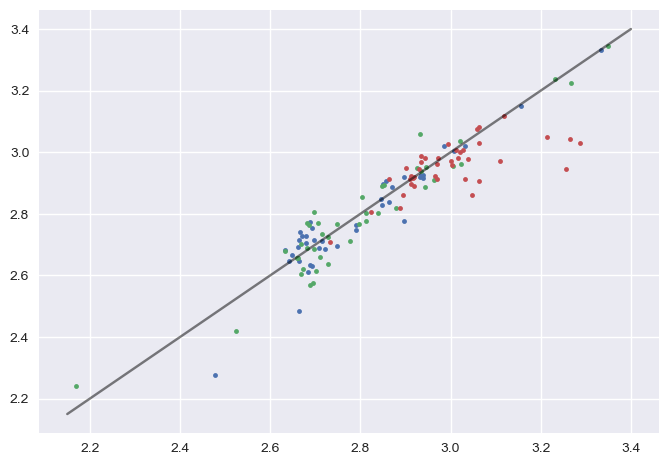

In [446]:
plt.plot(y[train_ind], model.elastic_net_predict(x[train_ind]).detach().numpy(), ".")
plt.plot(y[test_ind], model.elastic_net_predict(x[test_ind]).detach().numpy(), ".")
plt.plot(y[secondary_ind], model.elastic_net_predict(x[secondary_ind]).detach().numpy(), ".")
plt.plot(np.linspace(2.15, 3.4, 3), np.linspace(2.15, 3.4, 3), "k", alpha = 0.5)

# SVR

In [447]:
x_t = model.encoder(x[train_ind]).detach().numpy()
x_te = model.encoder(x[test_ind]).detach().numpy()
x_ste = model.encoder(x[secondary_ind]).detach().numpy()

print(x_t[0])

[0.         3.3895028  0.4337926  0.         2.1346564  0.
 2.507122   3.6117046  0.6522746  0.         0.         0.
 0.         3.7870576  0.6709192  0.         0.         0.
 0.         0.27587512 0.         0.         1.0313632  0.56990063
 0.         3.2735248  1.3762743  0.         0.         0.
 0.76554    3.5413952  0.         1.9708072  2.9834507  0.
 0.45168412 1.3873677  0.         0.5287509  3.6671822  0.515469
 0.         4.7042274  2.284802   0.         0.         0.        ]


In [448]:
# scaler = preprocessing.StandardScaler().fit(list(x_t))
# x_t = scaler.transform(list(x_t))
# x_te = scaler.transform(list(x_te))
# x_ste = scaler.transform(list(x_ste))

train = TensorDataset(torch.Tensor(x_t),torch.Tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x_te),torch.Tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x_ste),torch.Tensor(y[secondary_ind]))

In [457]:
# parameters
lr = 0.0005
feat_dim = 3*16
d_model = 10
nepoch = 1000
batch_size = 1

In [458]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
# Load nodel, loss function, and optimizer
model = AttentionModel(feat_dim=feat_dim,d_model=d_model)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label = batch
        output = model(train_input.to(device))
        loss = criterion(10**output, 10**train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(10**test_output, 10**test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(10**stest_output, 10**stest_label)
        

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

#wandb.finish()

Epochs: 50 | rmse:  106.199 | rmse_test:  100.662 | rmse_stest:  273.829
Epochs: 100 | rmse:  73.804 | rmse_test:  86.456 | rmse_stest:  269.909
Epochs: 150 | rmse:  71.564 | rmse_test:  88.508 | rmse_stest:  258.720
Epochs: 200 | rmse:  64.527 | rmse_test:  87.504 | rmse_stest:  258.119
Epochs: 250 | rmse:  70.385 | rmse_test:  85.684 | rmse_stest:  266.594
Epochs: 300 | rmse:  62.246 | rmse_test:  84.779 | rmse_stest:  261.476
Epochs: 350 | rmse:  80.391 | rmse_test:  101.046 | rmse_stest:  254.826
Epochs: 400 | rmse:  66.892 | rmse_test:  89.436 | rmse_stest:  270.628
Epochs: 450 | rmse:  80.866 | rmse_test:  91.558 | rmse_stest:  255.763
Epochs: 500 | rmse:  63.367 | rmse_test:  118.275 | rmse_stest:  297.327
Epochs: 550 | rmse:  62.382 | rmse_test:  95.012 | rmse_stest:  275.690
Epochs: 600 | rmse:  71.710 | rmse_test:  111.374 | rmse_stest:  259.249
Epochs: 650 | rmse:  88.207 | rmse_test:  84.625 | rmse_stest:  258.878
Epochs: 700 | rmse:  61.546 | rmse_test:  84.152 | rmse_stes

In [452]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

58.60678964842126
84.051869200088
253.52207237494372


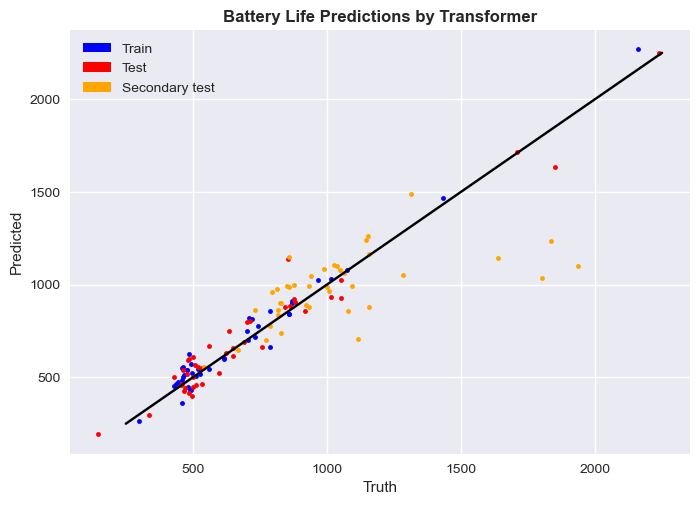

In [453]:
fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label = cell
        predicted.append(10**model(input[None,:].to(device)).detach().numpy()[0,0])
        labels.append(10**label)
    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
#plt.savefig("../images/transformer_output.png",dpi=300)